In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-04-09 20:45:22--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-04-09 20:45:23 (26.1 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



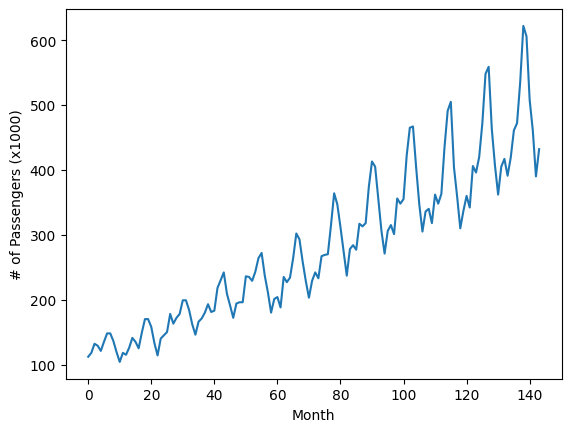

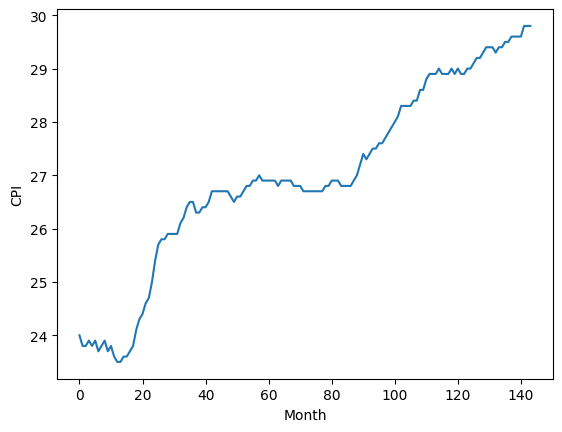

(144, 1) (144, 1)


In [249]:
# based on google colab here: https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb
# Additional data here: https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_ = pd.read_csv('airline-passengers.csv')
data_ = data_.iloc[:,1:2].values

data_cpi = pd.read_csv('us-cpi.csv', header=None)
data_cpi = np.array(data_cpi.iloc[:, 1:].values)
data_cpi = data_cpi.reshape(np.prod(data_cpi.shape), 1)

plt.plot(data_, label='Airline Passangers')
plt.xlabel('Month')
plt.ylabel('# of Passengers (x1000)')
plt.show()

plt.plot(data_cpi, label='US CPI')
plt.xlabel('Month')
plt.ylabel('CPI')
plt.show()

print(data_cpi.shape, data_.shape)

In [312]:
import torch
# data = data_cpi
# scale data wiht min-max scaling
data = (data_ - np.min(data_)) / (np.max(data_) - np.min(data_))
data_cpi = (data_cpi - np.min(data_cpi)) / (np.max(data_cpi) - np.min(data_cpi))
data = np.concatenate([data, data_cpi], axis=-1)

# window data
def window_data(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:i+seq_length])
        y.append(np.expand_dims(data[i+seq_length, 0], axis=-1))

    return x, y

x, y = window_data(data, 4)
x, y = np.array(x), np.array(y)

train_x, train_y = torch.Tensor(x[:int(len(x)*0.666)]), torch.Tensor(y[:int(len(y)*0.666)])
test_x, test_y = torch.Tensor(x[int(len(x)*0.666):]), torch.Tensor(y[int(len(y)*0.666):])
print(train_x.shape, train_y.shape)

all_data_x, all_data_y = torch.Tensor(x), torch.Tensor(y)

torch.Size([92, 4, 2]) torch.Size([92, 1])


In [371]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out[-1].view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [373]:
num_epochs = 10000
learning_rate = 0.01

input_size = 2
hidden_size = 8
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-4)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(train_x)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, train_y)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.09990
Epoch: 100, loss: 0.00332
Epoch: 200, loss: 0.00241
Epoch: 300, loss: 0.00195
Epoch: 400, loss: 0.00179
Epoch: 500, loss: 0.00175
Epoch: 600, loss: 0.00174
Epoch: 700, loss: 0.00174
Epoch: 800, loss: 0.00173
Epoch: 900, loss: 0.00173
Epoch: 1000, loss: 0.00172
Epoch: 1100, loss: 0.00171
Epoch: 1200, loss: 0.00171
Epoch: 1300, loss: 0.00170
Epoch: 1400, loss: 0.00170
Epoch: 1500, loss: 0.00170
Epoch: 1600, loss: 0.00170
Epoch: 1700, loss: 0.00169
Epoch: 1800, loss: 0.00171
Epoch: 1900, loss: 0.00169
Epoch: 2000, loss: 0.00169
Epoch: 2100, loss: 0.00169
Epoch: 2200, loss: 0.00169
Epoch: 2300, loss: 0.00170
Epoch: 2400, loss: 0.00169
Epoch: 2500, loss: 0.00169
Epoch: 2600, loss: 0.00170
Epoch: 2700, loss: 0.00169
Epoch: 2800, loss: 0.00169
Epoch: 2900, loss: 0.00169
Epoch: 3000, loss: 0.00169
Epoch: 3100, loss: 0.00169
Epoch: 3200, loss: 0.00169
Epoch: 3300, loss: 0.00169
Epoch: 3400, loss: 0.00169
Epoch: 3500, loss: 0.00169
Epoch: 3600, loss: 0.00169
Epoch: 3700, 

torch.Size([139, 1])


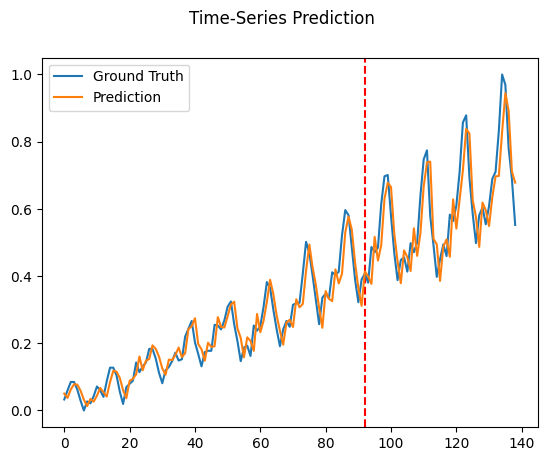

In [374]:
lstm.eval()
train_predict = lstm(all_data_x)
print(train_predict.shape)

data_predict = train_predict.data.numpy()
dataY_plot = all_data_y.data.numpy()

data_predict = data_predict
dataY_plot = dataY_plot

plt.axvline(x=len(train_x), c='r', linestyle='--')

plt.plot(dataY_plot, label='Ground Truth')
plt.plot(data_predict, label='Prediction')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

In [ ]:
import torch

# scale data wiht min-max scaling
data_ = (data_ - np.min(data_)) / (np.max(data_) - np.min(data_))
data_cpi_ = (data_cpi - np.min(data_cpi)) / (np.max(data_cpi) - np.min(data_cpi))

print(data_cpi_.shape, data_.shape)

data = data_ #np.concatenate([data_, data_cpi_], axis=-1)
print(data.shape)

# window data
def window_data(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])

    return x, y

x, y = window_data(data, 4)
x, y = np.array(x), np.array(y)

train_x, train_y = torch.Tensor(x[:int(len(x)*0.666)]), torch.Tensor(y[:int(len(y)*0.666)])
test_x, test_y = torch.Tensor(x[int(len(x)*0.666):]), torch.Tensor(y[int(len(y)*0.666):])
print(train_x.shape, train_y.shape)

all_data_x, all_data_y = torch.Tensor(x), torch.Tensor(y)